In [64]:
import numpy as np
import pycbc.waveform as pycbc_wf
import bilby
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt


import pycbc
from gwosc import datasets
from gwpy.timeseries import TimeSeries

In [65]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)
#    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    
#     waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
#         phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_time = time_array[1] - time_array[0]
#     time_bounds = ((time_array >= minimum_time) *
#                         (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',#'SpinTaylorT4',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency)
            #**waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

#     h_plus *= time_bounds
#     h_cross *= time_bounds
    
    tindex = np.argmax(h_plus)
    zeros_length = len(h_plus[tindex:])
    
    h_plus = h_plus[:tindex]
    h_cross = h_cross[:tindex]
    
    h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
    h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict(plus=h_plus, cross=h_cross)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


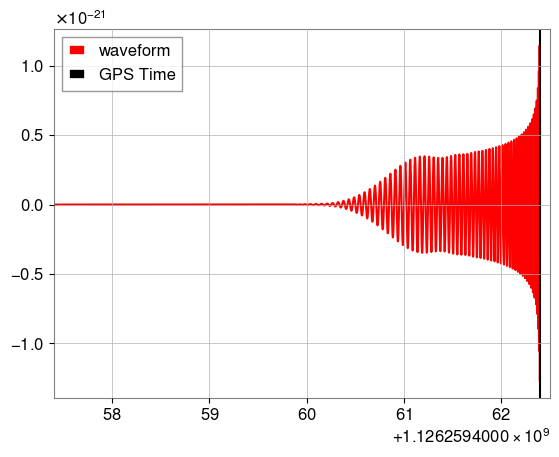

In [58]:
tg = 1126259462.4
t = np.arange(tg-10,tg,1/2048)
model = time_domain_model(t, 20, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

plt.plot(t,model,color='r',label='waveform')
plt.xlim([tg-5,tg+0.1])

plt.axvline(tg,color='k',label='GPS Time')
plt.legend()
plt.show()

In [66]:
logger = bilby.core.utils.logger
outdir = "outdir"
label = "GW150914"

In [67]:
# Note you can get trigger times using the gwosc package, e.g.:
# > from gwosc import datasets
# > datasets.event_gps("GW150914")

event = "GW150914"
trigger_time = datasets.event_gps(event)

detectors = ["H1", "L1"]
maximum_frequency = 1024
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration
post_trigger_duration = 0  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

sampling_frequency = 4096

In [68]:
psd_duration = 32 * duration
psd_start_time = start_time - psd_duration
psd_end_time = start_time

In [22]:
ifo_list = bilby.gw.detector.InterferometerList([])

In [70]:
ifo_list

[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(frequency_array=[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
  2.04800e+03], psd_array=[8.64648566e-42 1.93527217e-40 1.11732842e-41 ... 2.81622921e-50
  2.87963331e-50 5.19587617e-51], asd_array=[2.94049072e-21 1.39114060e-20 3.34264628e-21 ... 1.67816245e-25
  1.69694824e-25 7.20824262e-26]), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05),
 Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(frequency_array=[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
  2.04800e+03], psd_array=[9.37361558e-42 3.56140274e-43 2.29260086e-43 ... 1.91005140e-50
  3.14571766e-50 7.51034382e-51], asd_array=[3.06163610e-21 5.96774894e-22 4.78811117e-22 ... 1.38204609e-25
  1.77361711e-25 8.66622399e-26])

In [24]:
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.fetch_open_data(det, start_time, end_time)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

22:50 bilby INFO    : Downloading analysis data for ifo H1
22:50 bilby INFO    : Downloading psd data for ifo H1
22:54 bilby INFO    : Downloading analysis data for ifo L1
22:54 bilby INFO    : Downloading psd data for ifo L1
23:00 bilby INFO    : Saving data plots to outdir
23:00 bilby INFO    : Generating frequency domain strain from given time domain strain.
23:00 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
23:00 bilby INFO    : Generating frequency domain strain from given time domain strain.
23:00 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


In [25]:
dir(ifo_list[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filename_from_outdir_label_extension',
 '_load_docstring',
 '_save_ifo_docstring',
 'amplitude_spectral_density_array',
 'antenna_response',
 'calibration_model',
 'check_signal_duration',
 'detector_tensor',
 'duration',
 'elevation',
 'frequency_array',
 'frequency_domain_strain',
 'frequency_mask',
 'from_hdf5',
 'from_pickle',
 'geometry',
 'get_detector_response',
 'inject_signal',
 'inject_signal_from_waveform_generator',
 'inject_signal_from_waveform_polarizations',
 'inner_product',
 'latitude',
 'latitude_radians',
 'length',
 'longitude',
 'longitude_radians',
 'matched_filter_snr',
 'maximum_frequency',
 'met

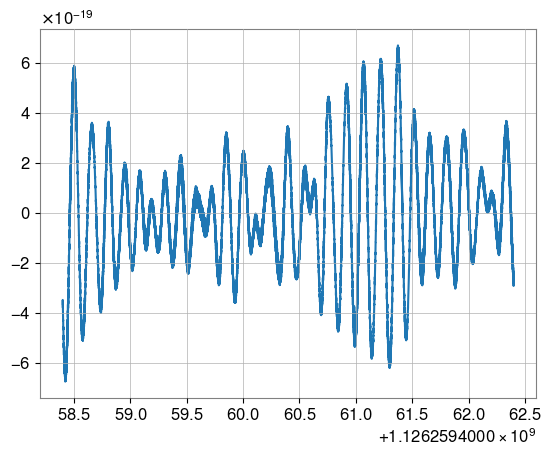

In [71]:
plt.plot(ifo_list[0].time_array, ifo_list[0].time_domain_strain)

In [72]:
priors = bilby.gw.prior.BBHPriorDict(filename="GW150914.prior")

In [73]:
priors

{'chirp_mass': UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None),
 'mass_ratio': UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'mass_1': Constraint(minimum=10, maximum=80, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=10, maximum=80, name='mass_2', latex_label='$m_2$', unit=None),
 'a_1': Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None),
 'a_2': Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None),
 'tilt_1': Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary=None),
 'tilt_2': Sine(minimum=0, maximum=3.141592653589793, name='tilt_2', latex_label='$\\theta_2$', unit=None, boundary=None),
 'phi_12': Uniform(minimum=0, maximum=6.283185307179586, name='phi_12', lat

In [34]:
priors.pop('geocent_time')

Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None)

In [74]:
injection_parameters = dict(
    
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    ra=1.375,
    dec=-1.2108,
    phase=1.3,
    geocent_time = trigger_time
)


for key in [
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "phase",
    "geocent_time",
]:
    priors[key] = injection_parameters[key]

In [75]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_model,
    start_time=start_time,
    
)

23:52 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_model
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [76]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifo_list, waveform_generator, priors=priors)

In [77]:
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    outdir=outdir,
    label=label,
    nlive=500,
    check_point_delta_t=600,
    check_point_plot=True,
    npool=1,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)

23:53 bilby INFO    : Running for label 'GW150914', output will be saved to 'outdir'
23:53 bilby INFO    : Using lal version 7.1.7
23:53 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
23:53 bilby INFO    : Using lalsimulation version 3.1.2
23:53 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
23:53 bilby INFO    : Search parameters:
23:53 bilby INFO    :   chirp_mass = UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
23:53 bilby INFO    :   mass_ratio = UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, bo

0it [00:00, ?it/s]

23:53 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fac4cd604f0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
23:53 bilby INFO    : Checkpoint every check_point_delta_t = 600s
23:53 bilby INFO    : Using dynesty version 1.0.1
23:53 bilby INFO    : Using the bil

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:03 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real dis

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:13 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real dis

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

00:54 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real dis

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

01:09 bilby INFO    : Sampling time: 1:16:20.039477
01:09 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/4290 [00:00<?, ?it/s]

01:09 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/4290 [00:00<?, ?it/s]

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
01:11 bilby INFO    : Summary of results:
nsamples: 4290
ln_noise_evidence: -12138.098
ln_evidence: -12135.240 +/-  0.118
ln_bayes_factor:  2.858 +/-  0.118



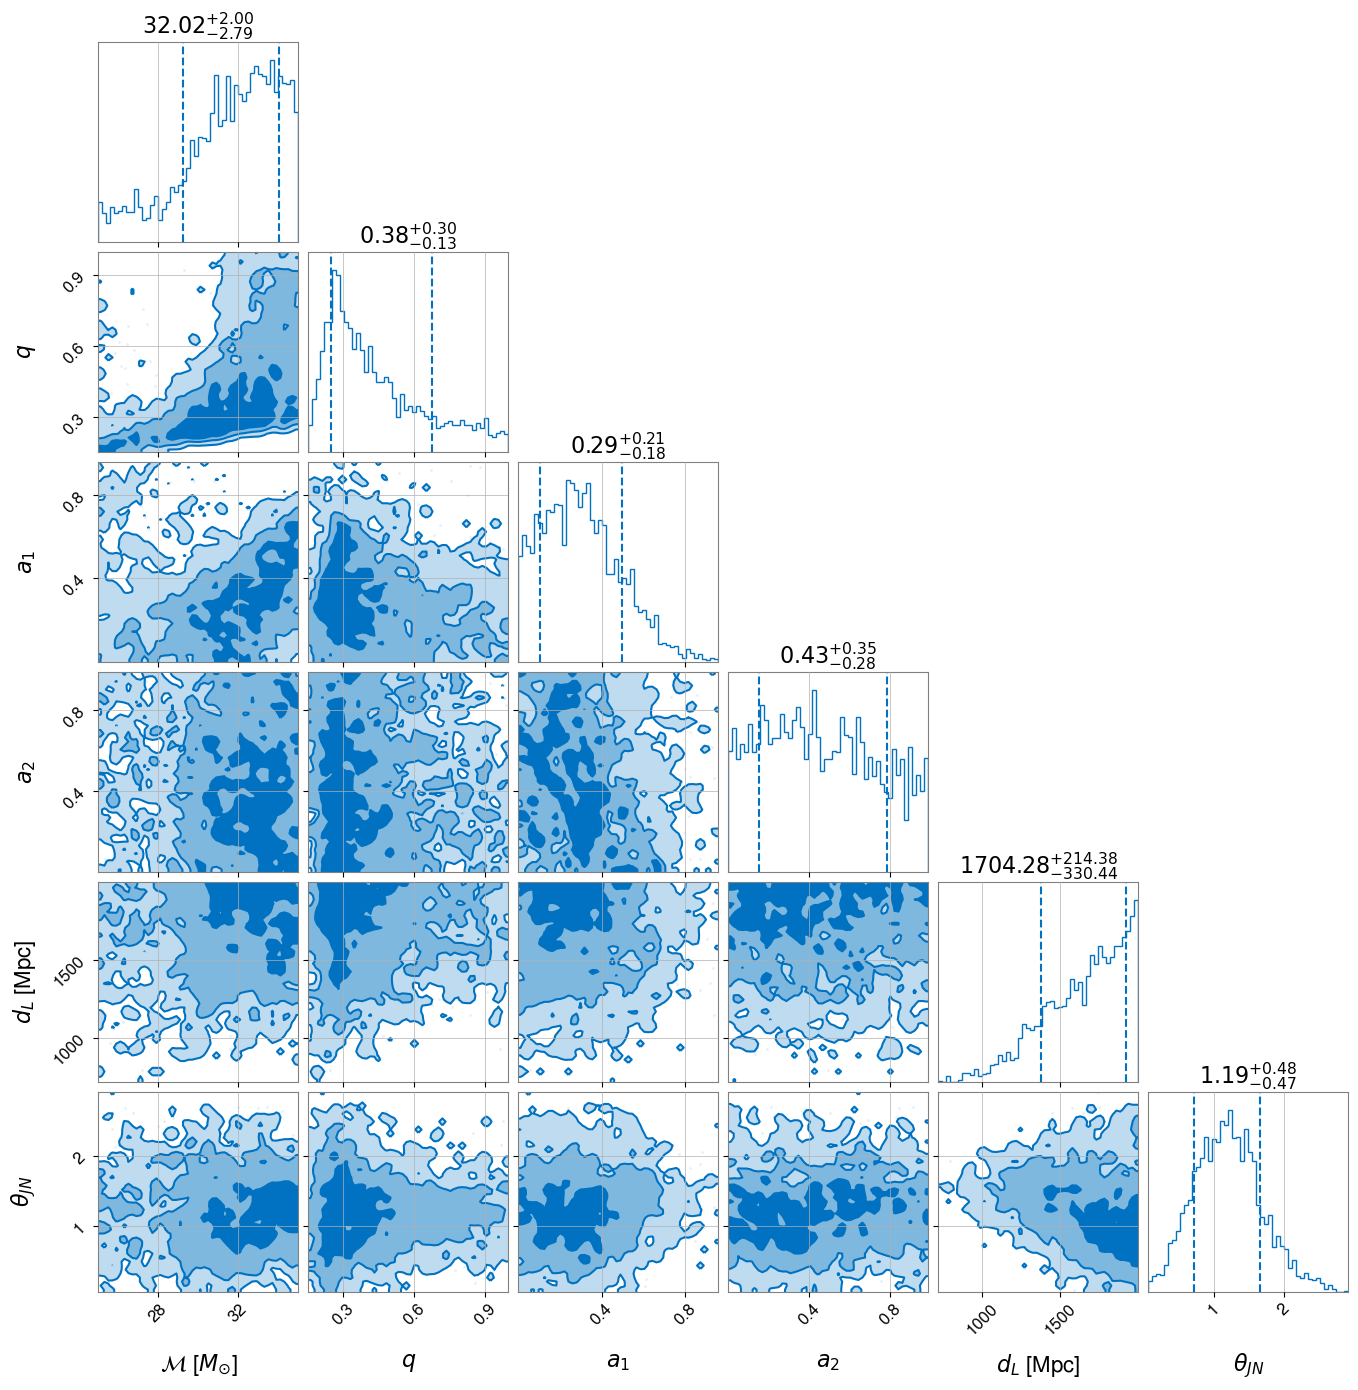

In [78]:
result.plot_corner()

In [79]:
res = bilby.core.result.Result(result)

In [80]:
res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior

,chirp_mass,mass_ratio,a_1,a_2,luminosity_distance,theta_jn,tilt_1,tilt_2,phi_12,phi_jl,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,33.034111,0.309064,0.520055,0.524536,1729.949553,0.904719,0.5,1.0,1.7,0.3,...,0.441381,0.249328,0.877583,0.540302,0.320750,1309.823356,53.395519,16.502649,25.011626,69.898167
1,30.429104,0.411160,0.751364,0.981470,1896.348181,0.879604,0.5,1.0,1.7,0.3,...,0.825878,0.360223,0.877583,0.540302,0.347141,1407.683063,41.246276,16.958816,22.587906,58.205093
2,29.887542,0.240288,0.247017,0.509139,917.767824,1.569230,0.5,1.0,1.7,0.3,...,0.428425,0.118426,0.877583,0.540302,0.183264,775.623817,62.040351,14.907522,25.258555,76.947873
3,28.583187,0.243221,0.286251,0.200370,1535.082867,1.993674,0.5,1.0,1.7,0.3,...,0.168606,0.137236,0.877583,0.540302,0.289171,1190.752362,54.089013,13.155597,22.171766,67.244610
4,32.858104,0.679464,0.295366,0.208628,1485.023936,1.066287,0.5,1.0,1.7,0.3,...,0.175554,0.141606,0.877583,0.540302,0.280931,1159.331457,35.879876,24.379084,25.651730,60.258960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4285,31.531718,0.334150,0.272609,0.512410,1944.841190,0.257288,0.5,1.0,1.7,0.3,...,0.431178,0.130696,0.877583,0.540302,0.354740,1435.582510,47.595717,15.904098,23.275105,63.499815
4286,34.162408,0.765677,0.264534,0.491883,1986.955383,0.818148,0.5,1.0,1.7,0.3,...,0.413905,0.305125,0.877583,0.540302,0.361307,1459.593988,33.002533,25.269285,25.095302,58.271818
4287,32.700974,0.822296,0.284519,0.187160,1838.386398,0.811309,0.5,1.0,1.7,0.3,...,0.157490,0.136406,0.877583,0.540302,0.338005,1373.975345,30.989161,25.482250,24.440092,56.471411
4288,34.542683,0.982133,0.470659,0.347895,1668.272668,0.992533,0.5,1.0,1.7,0.3,...,0.292744,0.286774,0.877583,0.540302,0.310837,1272.677428,30.544410,29.998674,26.351623,60.543084


In [49]:
pwd

'/home1/akash.mishra/Area_law/Notebooks'

In [81]:
mass_1 = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['mass_1_source']
mass_2 = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['mass_2_source']

(array([ 38., 359., 468., 547., 592., 671., 619., 591., 338.,
         67.]),
 array([24.10706075, 28.37857985, 32.65009896, 36.92161806,
        41.19313716, 45.46465626, 49.73617537, 54.00769447,
        58.27921357, 62.55073267, 66.82225177]),
 <BarContainer object of 10 artists>)

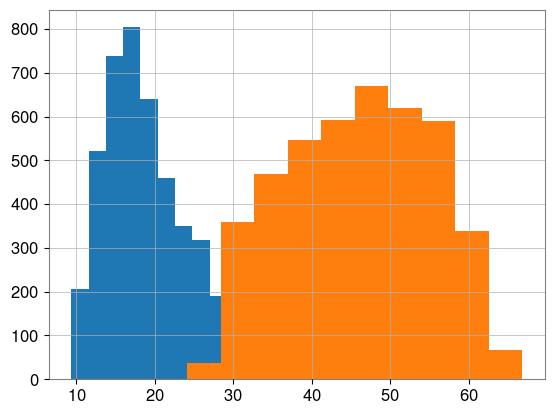

In [82]:
plt.hist(mass_2)
plt.hist(mass_1)

In [60]:
len(mass_2)

878

In [83]:
len(res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['chirp_mass'])

4290

In [84]:
4290/878

4.886104783599089